# Tutorial for making Akita predictions from a given 1MB genome sequence

Before running:
- set up a conda environment to run Akita following directions here: https://github.com/calico/basenji/tree/master
- follow instructions here to complete and test environment: https://github.com/calico/basenji/tree/master/manuscripts/akita
- add below packages to environment if needed
- make sure you have FASTA files for any sequences you'd like to predict on
- update file paths to match your system/directory structure

In [103]:
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import numpy as np
import math

import os
import json
from basenji import dataset, dna_io, seqnn
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from mpl_toolkits.axisartist.grid_finder import DictFormatter
from matplotlib.patches import Rectangle

In [105]:
def get_seq(chr, window_start, fasta_file_path):
    # load sequence to make predictions
    fasta_open = pysam.Fastafile(fasta_file_path)

    seq = fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return seq

def get_anc_seq(chr, window_start):
    # function to load in specified 1MB window from the included ancestral sequence
    anc_fasta_open = pysam.Fastafile('genomes/human_archaic_ancestor/human_archaic_ancestor_in_hg38_%s.fasta' % chr)

    anc_seq = anc_fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return anc_seq

def get_ref_seq_hg38(chr, window_start):
    # function to load in specified 1MB window from the included hg38 reference sequence
    ref_fasta_open = pysam.Fastafile('genomes/hg38/hg38_reference.fa')

    ref_seq = ref_fasta_open.fetch(chr, int(window_start), int(window_start)+2**20).upper()

    return ref_seq

def loadAkita():
    # function to load trained Akita model
    os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

    import tensorflow as tf
    if tf.__version__[0] == '1':
        tf.compat.v1.enable_eager_execution()

    with open('basenji/manuscripts/akita/params.json') as params_file:
        params = json.load(params_file)
        params_model = params['model']
        params_train = params['train']
        
    global seqnn_model
    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore('basenji/manuscripts/akita/model_best.h5')

def runAkitaPreds(seq):
    # function to run Akita predictions on a 1MB DNA sequence
    if len(seq) != 2**20: raise ValueError('len(seq) != seq_length') # check seq length
    seq_1hot = dna_io.dna_1hot(seq) # 1-hot encode sequence to be legible by the model
    test_pred_from_seq = seqnn_model.model.predict(np.expand_dims(seq_1hot,0)) # make predictions
    return test_pred_from_seq

def visualize_map(pred, window_start, indi, chrm, s=448, cbar=False, sat=1):
    # function for basic visualization of Akita prediction maps, feel free to customize to suit your needs
    # more complex versions of this function can be found in notebooks in the Github repo
    ind1_mat = from_upper_triu(pred, s, 2)
    mask =  np.tri(ind1_mat.shape[0], k = -1) # bottom-half
    ind1_mat = np.ma.array(ind1_mat, mask = mask).T # transpose

    # rotate matrix and add color
    if cbar: 
        fig1, axes=plt.subplots(1,figsize=(4,3))
    else:
        fig1, axes=plt.subplots(1,figsize=(3,3)) 
    fig1.delaxes(axes)
    ax = setup_axes1(fig1, 111, -45)

    _ = ax.matshow(ind1_mat, cmap = 'RdBu_r', vmin = -sat, vmax=sat)
    if cbar:
        c = fig1.colorbar(_, location='bottom', orientation = 'horizontal', shrink=0.4)
        for l in c.ax.xaxis.get_ticklabels():
            #l.set_fontproperties(arial)
            l.set_size(10)
    #plt.matshow(ind1_mat, cmap = 'RdBu_r')

    # add border to map
    ax.plot([-1, s-1], [0, s], color = 'black', linewidth = 1) # bottom line
    ax.plot([-1, s-1], [s, s], color = 'black', linewidth = 1) # right line
    ax.plot([-1, -1], [s, 0], color = 'black', linewidth = 1) # left line

    # add 'x-axis' ticks
    first = window_start + 65536
    rounded = math.ceil(first / 100000) * 100000
    diff = rounded - first
    cell = diff/2048
    
    x_list = np.arange(cell, 440, (100000/2048))
    for x in x_list:
        ax.plot(x, x, color = 'black', marker = '|', markersize = 5)
        
    # add 'x-axis' labels
    y_list = np.arange((rounded/1000000), ((rounded/1000000)+0.9), 0.1)
    for x, y in zip(x_list[::2], (y_list[::2])):
            ax.text(x+15, x-15, '%.1f' % y, horizontalalignment = 'center', verticalalignment = 'top', fontsize = 10)

    ax.text(0, -30, chrm, horizontalalignment = 'right', verticalalignment = 'top', fontsize = 10)

    ax.text(290, 140, indi, horizontalalignment = 'center', verticalalignment = 'center', fontsize = 10)
    
    #plt.savefig("akita_predictions/plots/%s_%s_%s.svg" % (chrm, str(window_start), indi), bbox_inches = 'tight')
    #plt.show()
    
    
    return ind1_mat

def from_upper_triu(vector_repr, matrix_len, num_diags):
    # get full matrix from upper triangle
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T


def set_diag(arr, x, i=0):
    # set diagonals of matrix
    start = max(i, -arr.shape[1] * i)
    stop = max(0, (arr.shape[1] - i)) * arr.shape[1]
    step = arr.shape[1] + 1
    arr.flat[start:stop:step] = x
    return arr


def setup_axes1(fig, rect, angle):
    # set up plot axes for proper rotation
    tr = Affine2D().scale(2, 2).rotate_deg(angle)

    #We create dictionarys to keep the xticks and yticks after the rotation
    dictio={i:str(val) for i,val in enumerate(np.arange(-.5, 449, 10).tolist())}
    reversedictio={i:dictio[val] for i,val in enumerate(list(reversed(sorted(dictio.keys()))))}
    grid_helper = floating_axes.GridHelperCurveLinear(
        tr, extremes=(-0.5, 448.5,-0.5, 448.5), tick_formatter1= DictFormatter(dictio),
        tick_formatter2=DictFormatter(reversedictio))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    # remove axes
    ax1.axis("off")    
    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_visible(False)
    ax1.axis["right"].set_visible(False)
    ax1.axis["left"].set_visible(False)


    fig.add_subplot(ax1) 
    aux_ax = ax1.get_aux_axes(tr)
    grid_helper.grid_finder.grid_locator1._nbins = 448    #Number of rows
    grid_helper.grid_finder.grid_locator2._nbins = 448    #Number of columns
    return aux_ax


In [16]:
# check directory and change if necessary
!pwd
#os.chdir('/wynton/group/capra/projects/modern_human_3Dgenome/EXAMPLE')

In [75]:
loadAkita()
# load in spearman correlation for 1KG~Ancestral and calculate 
# 3D divergence from ancestral for each individual from 1000 Genomes (1KG)
anc_spear = pd.read_table('anc_window_spearman.csv', sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear # we define 3D divergence as 1 minus the spearman correlation 
windows = list(anc_div.index)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1048576, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement_  ((None, 1048576, 4)  0          ['sequence[0][0]']               
 2 (StochasticReverseComplement  , ())                                                            
 )                                                                                                
                                                                                                  
 stochastic_shift_2 (Stochastic  (None, 1048576, 4)  0           ['stochastic_reverse_comple

## Make reference and ancestral predictions

To make your own predictions, substitute any fasta file or sequence you would like to the get_seq() function

In [146]:
# additionally, feel free to set any window positions you would like. We tiled the genome with 1MB windows overlapping by half, but if you are interested in a specific gene or variant consider centering on that position instead. 
w = windows[42]

1/1 [==============================] - 4s 4s/step


masked_array(
  data=[[nan, --, --, ..., --, --, --],
        [nan, nan, --, ..., --, --, --],
        [0.1413918435573578, nan, nan, ..., --, --, --],
        ...,
        [-0.08426615595817566, -0.11050871014595032, -0.1208375096321106,
         ..., nan, --, --],
        [-0.09250128269195557, -0.12297087907791138,
         -0.13278403878211975, ..., nan, nan, --],
        [-0.10274061560630798, -0.12929311394691467,
         -0.13819217681884766, ..., -0.012717992067337036, nan, nan]],
  mask=[[False,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False,  True,  True],
        [False, False, False, ..., False, False,  True],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

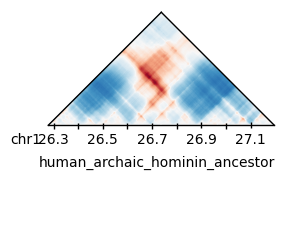

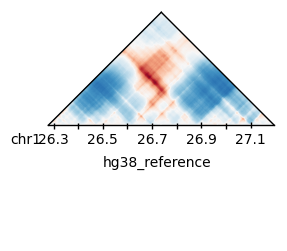

In [147]:

# anc_out = open(('3d_predictions_HFF_%s.txt' % ('human_archaic_hominin_ancestor')),'w')
# ref_out = open(('3d_predictions_HFF_%s.txt' % ('hg38_reference')),'w')

anc_seq = get_anc_seq(chr=w[0], window_start=w[1])
ref_seq = get_ref_seq_hg38(chr=w[0], window_start=w[1])

anc_pred = runAkitaPreds(anc_seq)
anc_pred = anc_pred[:,:,0][0]

ref_pred = runAkitaPreds(ref_seq)
ref_pred = ref_pred[:,:,0][0]

visualize_map(anc_pred, w[1], 'human_archaic_hominin_ancestor', w[0], sat=2)
visualize_map(ref_pred, w[1], 'hg38_reference', w[0], sat=2)

# anc_out.write(w[0] + "\t" + str(w[1]) + "\t" + "\t".join([str(x) for x in anc_pred]) + "\n")
# ref_out.write(w[0] + "\t" + str(w[1]) + "\t" + "\t".join([str(x) for x in ref_pred]) + "\n")

